In [ ]:
#Alexa Kozachok

In [2]:
#-----------------------------------------------
# code of this program borrowed from 
# Thuy Ng 
# https://github.com/thuyngch
# whith minor modifications
# source code has address
# https://github.com/thuyngch/Iris-Recognition
# and based on code belongs to
# Libor Masek, Peter Kovesi. MATLAB Source Code for a Biometric Identification System Based on Iris Patterns. 
# The School of Computer Science and Software Engineering, The University of Western Australia. 2003.
# https://www.peterkovesi.com/studentprojects/libor/sourcecode.html
#-----------------------------------------------


import cv2
import numpy as np
import multiprocessing as mp
from scipy.ndimage import convolve
from skimage.transform import radon
from scipy import signal

def encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf):
    """
    Description:
        Generate iris template and noise mask from the normalised iris region.
    Input:
        polar_array        - Normalised iris region.
        noise_array        - Normalised noise region.
        minWaveLength    - Base wavelength.
        mult            - Multicative factor between each filter.
        sigmaOnf        - Bandwidth parameter.
    Output:
        template        - The binary iris biometric template.
        mask            - The binary iris noise mask.
    """
    # Convolve normalised region with Gabor filters
    filterbank = gaborconvolve(polar_array, minWaveLength, mult, sigmaOnf)

 
    length = polar_array.shape[1]
    template = np.zeros([polar_array.shape[0], 2 * length])
    h = np.arange(polar_array.shape[0])

 
    # Create the iris template
    mask = np.zeros(template.shape)
    eleFilt = filterbank[:, :]

 
    # Phase quantization
    H1 = np.real(eleFilt) > 0
    H2 = np.imag(eleFilt) > 0

 
    # If amplitude is close to zero then phase data is not useful,
    # so mark off in the noise mask
    H3 = np.abs(eleFilt) < 0.0001
    for i in range(length):
        ja = 2 * i

 
        # Construct the biometric template
        template[:, ja] = H1[:, i]
        template[:, ja + 1] = H2[:, i]

 
        # Create noise mask
        mask[:, ja] = noise_array[:, i] | H3[:, i]
        mask[:, ja + 1] = noise_array[:, i] | H3[:, i]

 
    # Return
    return template, mask

 

def gaborconvolve(im, minWaveLength, mult, sigmaOnf):
    """
    Description:
        Convolve each row of an image with 1D log-Gabor filters.
    Input:
        im               - The image to be convolved.
        minWaveLength   - Wavelength of the basis filter.
        mult               - Multiplicative factor between each filter.
        sigmaOnf           - Ratio of the standard deviation of the
                          Gaussian describing the log Gabor filter's transfer
                          function in the frequency domain to the filter center
                          frequency.
    Output:
        filterbank        - The 1D cell array of complex valued convolution
                          resultsCircle coordinates.
    """
    # Pre-allocate
    rows, ndata = im.shape                    # Size
    logGabor = np.zeros(ndata)                # Log-Gabor
    filterbank = np.zeros([rows, ndata], dtype=complex)

 
    # Frequency values 0 - 0.5
    radius = np.arange(ndata/2 + 1) / (ndata/2) / 2
    radius[0] = 1

 
    # Initialize filter wavelength
    wavelength = minWaveLength

 
    # Calculate the radial filter component
    fo = 1 / wavelength         # Centre frequency of filter
    logGabor[0 : int(ndata/2) + 1] = np.exp((-(np.log(radius/fo))**2) / (2 * np.log(sigmaOnf)**2))
    logGabor[0] = 0

 
    # For each row of the input image, do the convolution
    for r in range(rows):
        signal = im[r, 0:ndata]
        imagefft = np.fft.fft(signal)
        filterbank[r , :] = np.fft.ifft(imagefft * logGabor)

 
    # Return
    return filterbank

 

def normalize(image, x_iris, y_iris, r_iris, x_pupil, y_pupil, r_pupil,
              radpixels, angulardiv):
    """
    Description:
        Normalize iris region by unwraping the circular region into a rectangular
        block of constant dimensions.
    Input:
        image        - Input iris image.
        x_iris        - x-coordinate of the circle defining the iris boundary.
        y_iris        - y-coordinate of the circle defining the iris boundary.
        r_iris        - Radius of the circle defining the iris boundary.
        x_pupil        - x-coordinate of the circle defining the pupil boundary.
        y_pupil        - y-coordinate of the circle defining the pupil boundary.
        r_pupil        - Radius of the circle defining the pupil boundary.
        radpixels    - Radial resolution (vertical dimension).
        angulardiv    - Angular resolution (horizontal dimension).
    Output:
        polar_array    - Normalized form of the iris region.
        polar_noise    - Normalized form of the noise region.
    """
    radiuspixels = radpixels + 2
    angledivisions = angulardiv-1

 
    r = np.arange(radiuspixels)
    theta = np.linspace(0, 2*np.pi, angledivisions+1)

 
    # Calculate displacement of pupil center from the iris center
    ox = x_pupil - x_iris
    oy = y_pupil - y_iris

 
    if ox <= 0:
        sgn = -1
    elif ox > 0:
        sgn = 1

 
    if ox==0 and oy > 0:
        sgn = 1

 
    a = np.ones(angledivisions+1) * (ox**2 + oy**2)

 
    # Need to do something for ox = 0
    if ox == 0:
        phi = np.pi/2
    else:
        phi = np.arctan(oy/ox)

 
    b = sgn * np.cos(np.pi - phi - theta)

 
    # Calculate radius around the iris as a function of the angle
    r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - r_iris**2))
    r = np.array([r - r_pupil])

 
    rmat = np.dot(np.ones([radiuspixels,1]), r)

 
    rmat = rmat * np.dot(np.ones([angledivisions+1,1]),
                            np.array([np.linspace(0,1,radiuspixels)])).transpose()
    rmat = rmat + r_pupil

 
    # Exclude values at the boundary of the pupil iris border, and the iris scelra border
    # as these may not correspond to areas in the iris region and will introduce noise.
    # ie don't take the outside rings as iris data.
    rmat = rmat[1 : radiuspixels-1, :]

 
    # Calculate cartesian location of each data point around the circular iris region
    xcosmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.cos(theta)]))
    xsinmat = np.dot(np.ones([radiuspixels-2,1]), np.array([np.sin(theta)]))

 
    xo = rmat * xcosmat
    yo = rmat * xsinmat

 
    xo = x_pupil + xo
    xo = np.round(xo).astype(int)
    coords = np.where(xo >= image.shape[1])
    xo[coords] = image.shape[1] - 1
    coords = np.where(xo < 0)
    xo[coords] = 0
    
    yo = y_pupil - yo
    yo = np.round(yo).astype(int)
    coords = np.where(yo >= image.shape[0])
    yo[coords] = image.shape[0] - 1
    coords = np.where(yo < 0)
    yo[coords] = 0

 
    # Extract intensity values into the normalised polar representation through
    # interpolation
    # x,y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    # f = interpolate.interp2d(x, y, image, kind='linear')
    # polar_array = f(xo, yo)
    # polar_array = polar_array / 255

 
    polar_array = image[yo, xo]
    polar_array = polar_array / 255

 
    # Create noise array with location of NaNs in polar_array
    polar_noise = np.zeros(polar_array.shape)
    coords = np.where(np.isnan(polar_array))
    polar_noise[coords] = 1

 
    # Get rid of outling points in order to write out the circular pattern
    image[yo, xo] = 255

 
    # Get pixel coords for circle around iris
    x,y = circlecoords([x_iris,y_iris], r_iris, image.shape)
    image[y,x] = 255

 
    # Get pixel coords for circle around pupil
    xp,yp = circlecoords([x_pupil,y_pupil], r_pupil, image.shape)
    image[yp,xp] = 255

 
    # Replace NaNs before performing feature encoding
    coords = np.where((np.isnan(polar_array)))
    polar_array2 = polar_array
    polar_array2[coords] = 0.5
    avg = np.sum(polar_array2) / (polar_array.shape[0] * polar_array.shape[1])
    polar_array[coords] = avg

 
    return polar_array, polar_noise.astype(bool)

 

def circlecoords(c, r, imgsize, nsides=600):
    """
    Description:
        Find the coordinates of a circle based on its centre and radius.
    Input:
        c       - Centre of the circle.
        r          - Radius of the circle.
        imgsize - Size of the image that the circle will be plotted onto.
        nsides     - Number of sides of the convex-hull bodering the circle
                  (default as 600).
    Output:
        x,y     - Circle coordinates.
    """
    a = np.linspace(0, 2*np.pi, 2*nsides+1)
    xd = np.round(r * np.cos(a) + c[0])
    yd = np.round(r * np.sin(a) + c[1])

 
    #  Get rid of values larger than image
    xd2 = xd
    coords = np.where(xd >= imgsize[1])
    xd2[coords[0]] = imgsize[1] - 1
    coords = np.where(xd < 0)
    xd2[coords[0]] = 0

 
    yd2 = yd
    coords = np.where(yd >= imgsize[0])
    yd2[coords[0]] = imgsize[0] - 1
    coords = np.where(yd < 0)
    yd2[coords[0]] = 0

 
    x = np.round(xd2).astype(int)
    y = np.round(yd2).astype(int)
    return x,y

 

def findline(img):
    """
    Description:
        Find lines in an image.
        Linear Hough transform and Canny edge detection are used.
    Input:
        img     - The input image.
    Output:
        lines   - Parameters of the detected line in polar form.
    """
    # Pre-processing
    I2, orient = canny(img, 2, 0, 1)
    I3 = adjgamma(I2, 1.9)
    I4 = nonmaxsup(I3, orient, 1.5)
    edgeimage = hysthresh(I4, 0.2, 0.15)

 
    # Radon transformation
    theta = np.arange(180)
    R = radon(edgeimage, theta, circle=False)
    sz = R.shape[0] // 2
    xp = np.arange(-sz, sz+1, 1)

 
    # Find for the strongest edge
    maxv = np.max(R)
    if maxv > 25:
        i = np.where(R.ravel() == maxv)
        i = i[0]
    else:
        return np.array([])

 
    R_vect = R.ravel()
    ind = np.argsort(-R_vect[i])
    u = i.shape[0]
    k = i[ind[0: u]]
    y, x = np.unravel_index(k, R.shape)
    t = -theta[x] * np.pi / 180
    r = xp[y]

 
    lines = np.vstack([np.cos(t), np.sin(t), -r]).transpose()
    cx = img.shape[1] / 2 - 1
    cy = img.shape[0] / 2 - 1
    lines[:, 2] = lines[:,2] - lines[:,0]*cx - lines[:,1]*cy
    return lines

 

def linecoords(lines, imsize):
    """
    Description:
        Find x-, y- coordinates of positions along a line.
    Input:
        lines   - Parameters (polar form) of the line.
        imsize  - Size of the image.
    Output:
        x,y     - Resulting coordinates.
    """
    xd = np.arange(imsize[1])
    yd = (-lines[0,2] - lines[0,0] * xd) / lines[0,1]

 
    coords = np.where(yd >= imsize[0])
    coords = coords[0]
    yd[coords] = imsize[0]-1
    coords = np.where(yd < 0)
    coords = coords[0]
    yd[coords] = 0

 
    x = xd
    y = yd
    return x, y

 

def canny(im, sigma, vert, horz):
    """
    Description:
        Canny edge detection.
    Input:
        im      - The input image.
        sigma   - Standard deviation of Gaussian smoothing filter.
        vert    - Weighting for vertical gradients.
        horz    - Weighting for horizontal gradients.
    Output:
        grad    - Edge strength (gradient amplititude)
        orient  - Orientation image (0-180, positive, anti-clockwise)
    """

 
    def fspecial_gaussian(shape=(3, 3), sig=1):
        m, n = [(ss - 1) / 2 for ss in shape]
        y, x = np.ogrid[-m:m + 1, -n:n + 1]
        f = np.exp(-(x * x + y * y) / (2 * sig * sig))
        f[f < np.finfo(f.dtype).eps * f.max()] = 0
        sum_f = f.sum()
        if sum_f != 0:
            f /= sum_f
        return f

 
    hsize = [6 * sigma + 1, 6 * sigma + 1]  # The filter size
    gaussian = fspecial_gaussian(hsize, sigma)
    im = convolve(im, gaussian, mode='constant')  # Smoothed image
    rows, cols = im.shape

 
    h = np.concatenate([im[:, 1:cols], np.zeros([rows,1])], axis=1) - \
        np.concatenate([np.zeros([rows, 1]), im[:, 0: cols - 1]], axis=1)

 
    v = np.concatenate([im[1: rows, :], np.zeros([1, cols])], axis=0) - \
        np.concatenate([np.zeros([1, cols]), im[0: rows - 1, :]], axis=0)

 
    d11 = np.concatenate([im[1:rows, 1:cols], np.zeros([rows - 1, 1])], axis=1)
    d11 = np.concatenate([d11, np.zeros([1, cols])], axis=0)
    d12 = np.concatenate([np.zeros([rows-1, 1]), im[0:rows - 1, 0:cols - 1]], axis=1)
    d12 = np.concatenate([np.zeros([1, cols]), d12], axis=0)
    d1 = d11 - d12

 
    d21 = np.concatenate([im[0:rows - 1, 1:cols], np.zeros([rows - 1, 1])], axis=1)
    d21 = np.concatenate([np.zeros([1, cols]), d21], axis=0)
    d22 = np.concatenate([np.zeros([rows - 1, 1]), im[1:rows, 0:cols - 1]], axis=1)
    d22 = np.concatenate([d22, np.zeros([1, cols])], axis=0)
    d2 = d21 - d22

 
    X = (h + (d1 + d2) / 2) * vert
    Y = (v + (d1 - d2) / 2) * horz

 
    gradient = np.sqrt(X * X + Y * Y)  # Gradient amplitude

 
    orient = np.arctan2(-Y, X)  # Angles -pi to +pi
    neg = orient < 0  # Map angles to 0-pi
    orient = orient * ~neg + (orient + np.pi) * neg
    orient = orient * 180 / np.pi  # Convert to degrees

 
    return gradient, orient

 

def adjgamma(im, g):
    """
    Description:
        Adjust image gamma.
    Input:
        im      - The input image.
        g       - Image gamma value.
                  Range (0, 1] enhances contrast of bright region.
                  Range (1, inf) enhances contrast of dark region.
    Output:
        newim   - The adjusted image.
    """
    newim = im
    newim = newim - np.min(newim)
    newim = newim / np.max(newim)
    newim = newim ** (1 / g)  # Apply gamma function
    return newim

 

def nonmaxsup(in_img, orient, radius):
    """
    Description:
        Perform non-maxima suppression on an image using an orientation image
    Input:
        in_img  - The input image
        orient  - Image containing feature normal orientation angles
        radius  - Distance to be looked at on each side of each pixel when
                  determining whether it is a local maxima or not (1.2 - 1.5)
    Output:
        im_out  - The suppressed image
    """
    # Preallocate memory for output image for speed
    rows, cols = in_img.shape
    im_out = np.zeros([rows, cols])
    iradius = np.ceil(radius).astype(int)

 
    # Pre-calculate x and y offsets relative to centre pixel for each orientation angle
    angle = np.arange(181) * np.pi / 180  # Angles in 1 degree increments (in radians)
    xoff = radius * np.cos(angle)  # x and y offset of points at specified radius and angle
    yoff = radius * np.sin(angle)  # from each reference position

 
    hfrac = xoff - np.floor(xoff)  # Fractional offset of xoff relative to integer location
    vfrac = yoff - np.floor(yoff)  # Fractional offset of yoff relative to integer location

 
    orient = np.fix(orient)

 
    # Now run through the image interpolating grey values on each side
    # of the centre pixel to be used for the non-maximal suppression
    col, row = np.meshgrid(np.arange(iradius, cols - iradius),
                           np.arange(iradius, rows - iradius))

 
    # Index into precomputed arrays
    ori = orient[row, col].astype(int)

 
    # x, y location on one side of the point in question
    x = col + xoff[ori]
    y = row - yoff[ori]

 
    # Get integer pixel locations that surround location x,y
    fx = np.floor(x).astype(int)
    cx = np.ceil(x).astype(int)
    fy = np.floor(y).astype(int)
    cy = np.ceil(y).astype(int)

 
    # Value at integer pixel locations
    tl = in_img[fy, fx]  # top left
    tr = in_img[fy, cx]  # top right
    bl = in_img[cy, fx]  # bottom left
    br = in_img[cy, cx]  # bottom right

 
    # Bi-linear interpolation to estimate value at x,y
    upperavg = tl + hfrac[ori] * (tr - tl)
    loweravg = bl + hfrac[ori] * (br - bl)
    v1 = upperavg + vfrac[ori] * (loweravg - upperavg)

 
    # Check the value on the other side
    map_candidate_region = in_img[row, col] > v1

 
    x = col - xoff[ori]
    y = row + yoff[ori]

 
    fx = np.floor(x).astype(int)
    cx = np.ceil(x).astype(int)
    fy = np.floor(y).astype(int)
    cy = np.ceil(y).astype(int)

 
    tl = in_img[fy, fx]
    tr = in_img[fy, cx]
    bl = in_img[cy, fx]
    br = in_img[cy, cx]

 
    upperavg = tl + hfrac[ori] * (tr - tl)
    loweravg = bl + hfrac[ori] * (br - bl)
    v2 = upperavg + vfrac[ori] * (loweravg - upperavg)

 
    # Local maximum
    map_active = in_img[row, col] > v2
    map_active = map_active * map_candidate_region
    im_out[row, col] = in_img[row, col] * map_active

 
    return im_out

 

def hysthresh(im, T1, T2):
    """
    Description:
        Hysteresis thresholding.
    Input:
        im  - The input image.
        T1  - The upper threshold value.
        T2  - The lower threshold value
    Output:
        bw  - The binarized image.
    """
    # Pre-compute some values for speed and convenience
    rows, cols = im.shape
    rc = rows * cols
    rcmr = rc - rows
    rp1 = rows + 1

 
    bw = im.ravel()  # Make image into a column vector
    pix = np.where(bw > T1) # Find indices of all pixels with value > T1
    pix = pix[0]
    npix = pix.size         # Find the number of pixels with value > T1

 
    # Create a stack array (that should never overflow)
    stack = np.zeros(rows * cols)
    stack[0:npix] = pix         # Put all the edge points on the stack
    stp = npix  # set stack pointer
    for k in range(npix):
        bw[pix[k]] = -1         # Mark points as edges

 
    # Pre-compute an array, O, of index offset values that correspond to the eight
    # surrounding pixels of any point. Note that the image was transformed into
    # a column vector, so if we reshape the image back to a square the indices
    # surrounding a pixel with index, n, will be:
    #              n-rows-1   n-1   n+rows-1
    #
    #               n-rows     n     n+rows
    #
    #              n-rows+1   n+1   n+rows+1

 
    O = np.array([-1, 1, -rows - 1, -rows, -rows + 1, rows - 1, rows, rows + 1])

 
    while stp != 0:  # While the stack is not empty
        v = int(stack[stp-1])  # Pop next index off the stack
        stp -= 1

 
        if rp1 < v < rcmr:  # Prevent us from generating illegal indices
            # Now look at surrounding pixels to see if they should be pushed onto
            # the stack to be processed as well
            index = O + v  # Calculate indices of points around this pixel.
            for l in range(8):
                ind = index[l]
                if bw[ind] > T2:  # if value > T2,
                    stp += 1  # push index onto the stack.
                    stack[stp-1] = ind
                    bw[ind] = -1  # mark this as an edge point

 
    bw = (bw == -1)  # Finally zero out anything that was not an edge
    bw = np.reshape(bw, [rows, cols])  # Reshape the image
    return bw

 

def searchInnerBound(img):
    """
    Description:
        Search for the inner boundary of the iris.
    Input:
        img        - The input iris image.
    Output:
        inner_y    - y-coordinate of the inner circle centre.
        inner_x    - x-coordinate of the inner circle centre.
        inner_r    - Radius of the inner circle.
    """

 
    # Integro-Differential operator coarse (jump-level precision)
    Y = img.shape[0]
    X = img.shape[1]
    sect = X/4         # Width of the external margin for which search is excluded
    minrad = 10
    maxrad = sect*0.8
    jump = 4         # Precision of the coarse search, in pixels

 
    # Hough Space (y,x,r)
    sz = np.array([np.floor((Y-2*sect)/jump),
                    np.floor((X-2*sect)/jump),
                    np.floor((maxrad-minrad)/jump)]).astype(int)

 
    # Resolution of the circular integration
    integrationprecision = 1
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(sz[1]),
                          np.arange(sz[0]),
                          np.arange(sz[2]))
    y = sect + y*jump
    x = sect + x*jump
    r = minrad + r*jump
    hs = ContourIntegralCircular(img, y, x, r, angs)

 
    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

 
    # Blur
    sm = 3         # Size of the blurring mask
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")

 
    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

 
    inner_y = sect + y*jump
    inner_x = sect + x*jump
    inner_r = minrad + (r-1)*jump

 
    # Integro-Differential operator fine (pixel-level precision)
    integrationprecision = 0.1         # Resolution of the circular integration
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(jump*2),
                          np.arange(jump*2),
                          np.arange(jump*2))
    y = inner_y - jump + y
    x = inner_x - jump + x
    r = inner_r - jump + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

 
    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

 
    # Bluring
    sm = 3         # Size of the blurring mask
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")
    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

 
    inner_y = inner_y - jump + y
    inner_x = inner_x - jump + x
    inner_r = inner_r - jump + r - 1

 
    return inner_y, inner_x, inner_r

 

def searchOuterBound(img, inner_y, inner_x, inner_r):
    """
    Description:
        Search for the outer boundary of the iris.
    Input:
        img        - The input iris image.
        inner_y    - The y-coordinate of the inner circle centre.
        inner_x    - The x-coordinate of the inner circle centre.
        inner_r    - The radius of the inner circle.
    Output:
        outer_y    - y-coordinate of the outer circle centre.
        outer_x    - x-coordinate of the outer circle centre.
        outer_r    - Radius of the outer circle.
    """
    # Maximum displacement 15# (Daugman 2004)
    maxdispl = np.round(inner_r*0.15).astype(int)

 
    # 0.1 - 0.8 (Daugman 2004)
    minrad = np.round(inner_r/0.8).astype(int)
    maxrad = np.round(inner_r/0.3).astype(int)

 
    # # Hough Space (y,x,r)
    # hs = np.zeros([2*maxdispl, 2*maxdispl, maxrad-minrad])

 
    # Integration region, avoiding eyelids
    intreg = np.array([[2/6, 4/6], [8/6, 10/6]]) * np.pi

 
    # Resolution of the circular integration
    integrationprecision = 0.05
    angs = np.concatenate([np.arange(intreg[0,0], intreg[0,1], integrationprecision),
                            np.arange(intreg[1,0], intreg[1,1], integrationprecision)],
                            axis=0)
    x, y, r = np.meshgrid(np.arange(2*maxdispl),
                          np.arange(2*maxdispl),
                          np.arange(maxrad-minrad))
    y = inner_y - maxdispl + y
    x = inner_x - maxdispl + x
    r = minrad + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

 
    # Hough Space Partial Derivative R
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

 
    # Blur
    sm = 7     # Size of the blurring mask
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")

 
    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

 
    outer_y = inner_y - maxdispl + y + 1
    outer_x = inner_x - maxdispl + x + 1
    outer_r = minrad + r - 1

 
    return outer_y, outer_x, outer_r

 

def ContourIntegralCircular(imagen, y_0, x_0, r, angs):
    """
    Description:
        Performs contour (circular) integral.
        Use discrete Rie-mann approach.
    Input:
        imagen  - The input iris image.
        y_0     - The y-coordinate of the circle centre.
        x_0     - The x-coordinate of the circle centre.
        r       - The radius of the circle.
        angs    - The region of the circle considering clockwise 0-2pi.
    Output:
        hs      - Integral result.
    """
    # Get y, x
    y = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    x = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    for i in range(len(angs)):
        ang = angs[i]
        y[i, :, :, :] = np.round(y_0 - np.cos(ang) * r).astype(int)
        x[i, :, :, :] = np.round(x_0 + np.sin(ang) * r).astype(int)

 
    # Adapt y
    ind = np.where(y < 0)
    y[ind] = 0
    ind = np.where(y >= imagen.shape[0])
    y[ind] = imagen.shape[0] - 1

 
    # Adapt x
    ind = np.where(x < 0)
    x[ind] = 0
    ind = np.where(x >= imagen.shape[1])
    x[ind] = imagen.shape[1] - 1

 
    # Return
    hs = imagen[y, x]
    hs = np.sum(hs, axis=0)
    return hs.astype(float)

 

def segment(eyeim, eyelashes_thres=80, use_multiprocess=True):
    """
    Description:
        Segment the iris region from the eye image.
        Indicate the noise region.
    Input:
        eyeim                - Eye image
        eyelashes_thres       - Eyelashes threshold
        use_multiprocess       - Use multiprocess to run
    Output:
        ciriris        - Centre coordinates and radius of iris boundary.
        cirpupil    - Centre coordinates and radius of pupil boundary.
        imwithnoise    - Original image with location of noise marked with NaN.
    """
    # Find the iris boundary by Daugman's intefro-differential
    rowp, colp, rp = searchInnerBound(eyeim)
    row, col, r = searchOuterBound(eyeim, rowp, colp, rp)

 
    # Package pupil and iris boundaries
    rowp = np.round(rowp).astype(int)
    colp = np.round(colp).astype(int)
    rp = np.round(rp).astype(int)
    row = np.round(row).astype(int)
    col = np.round(col).astype(int)
    r = np.round(r).astype(int)
    cirpupil = [rowp, colp, rp]
    ciriris = [row, col, r]

 
    # Find top and bottom eyelid
    imsz = eyeim.shape
    irl = np.round(row - r).astype(int)
    iru = np.round(row + r).astype(int)
    icl = np.round(col - r).astype(int)
    icu = np.round(col + r).astype(int)
    if irl < 0:
        irl = 0
    if icl < 0:
        icl = 0
    if iru >= imsz[0]:
        iru = imsz[0] - 1
    if icu >= imsz[1]:
        icu = imsz[1] - 1
    imageiris = eyeim[irl: iru + 1, icl: icu + 1]

 
    # If use_multiprocess
    if use_multiprocess:
        ret_top = mp.Manager().dict()
        ret_bot = mp.Manager().dict()
        p_top = mp.Process(
            target=findTopEyelid,
            args=(imsz, imageiris, irl, icl, rowp, rp, ret_top),
        )
        p_bot = mp.Process(
            target=findBottomEyelid,
            args=(imsz, imageiris, rowp, rp, irl, icl, ret_bot),
        )
        p_top.start()
        p_bot.start()
        p_top.join()
        p_bot.join()
        mask_top = ret_top[0]
        mask_bot = ret_bot[0]

 
    # If not use_multiprocess
    else:
        mask_top = findTopEyelid(imsz, imageiris, irl, icl, rowp, rp)
        mask_bot = findBottomEyelid(imsz, imageiris, rowp, rp, irl, icl)

 
    # Mask the eye image, noise region is masked by NaN value
    imwithnoise = eyeim.astype(float)
    imwithnoise = imwithnoise + mask_top + mask_bot

 
    # For CASIA, eliminate eyelashes by threshold
    ref = eyeim < eyelashes_thres
    coords = np.where(ref == 1)
    imwithnoise[coords] = np.nan

 
    return ciriris, cirpupil, imwithnoise

 

def findTopEyelid(imsz, imageiris, irl, icl, rowp, rp, ret_top=None):
    """
    Description:
        Mask for the top eyelid region.
    Input:
        imsz        - Size of the eye image.
        imageiris    - Image of the iris region.
        irl            -
        icl            -
        rowp        - y-coordinate of the inner circle centre.
        rp            - radius of the inner circle centre.
        ret_top        - Just used for returning result when using multiprocess.
    Output:
        mask        - Map of noise that will be masked with NaN values.
    """
    topeyelid = imageiris[0: rowp - irl - rp, :]
    lines = findline(topeyelid)
    mask = np.zeros(imsz, dtype=float)

 
    if lines.size > 0:
        xl, yl = linecoords(lines, topeyelid.shape)
        yl = np.round(yl + irl - 1).astype(int)
        xl = np.round(xl + icl - 1).astype(int)

 
        yla = np.max(yl)
        y2 = np.arange(yla)

 
        mask[yl, xl] = np.nan
        grid = np.meshgrid(y2, xl)
        mask[grid] = np.nan

 
    # Return
    if ret_top is not None:
        ret_top[0] = mask
    return mask

 

def findBottomEyelid(imsz, imageiris, rowp, rp, irl, icl, ret_bot=None):
    """
    Description:
        Mask for the bottom eyelid region.
    Input:
        imsz        - Eye image.
        imageiris    - Image of the iris region.
        rowp        - y-coordinate of the inner circle centre.
        rp            - radius of the inner circle centre.
        irl            -
        icl            -
        ret_bot        - Just used for returning result when using multiprocess.
    Output:
        mask        - Map of noise that will be masked with NaN values.
    """
    bottomeyelid = imageiris[rowp - irl + rp - 1 : imageiris.shape[0], :]
    lines = findline(bottomeyelid)
    mask = np.zeros(imsz, dtype=float)

 
    if lines.size > 0:
        xl, yl = linecoords(lines, bottomeyelid.shape)
        yl = np.round(yl + rowp + rp - 3).astype(int)
        xl = np.round(xl + icl - 2).astype(int)
        yla = np.min(yl)
        y2 = np.arange(yla-1, imsz[0])

 
        mask[yl, xl] = np.nan
        grid = np.meshgrid(y2, xl)
        mask[grid] = np.nan

 
    # Return
    if ret_bot is not None:
        ret_bot[0] = mask
    return mask

 

eyelashes_thres = 80

 

#radial_res = 20
#angular_res = 16

 

minWaveLength = 18
mult = 1
sigmaOnf = 0.5

 

def extractFeature(im_filename, radial_res, angular_res, eyelashes_thres=80, use_multiprocess=False):
    """
    Description:
        Extract features from an iris image

 
    Input:
        im_filename            - The input iris image
        use_multiprocess    - Use multiprocess to run

 
    Output:
        template            - The extracted template
        mask                - The extracted mask
        im_filename            - The input iris image
    """
    # Perform segmentation
    im = cv2.imread(im_filename, 0)
    ciriris, cirpupil, imwithnoise = segment(im, eyelashes_thres, use_multiprocess)

 
    # Perform normalization
    polar_array, noise_array = normalize(imwithnoise, ciriris[1], ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_res, angular_res)

 
    # Perform feature encoding
    template, mask = encode(polar_array, noise_array, minWaveLength, mult, sigmaOnf)

 
    # Return
    return template, mask, im_filename

In [27]:
#

In [18]:
class Alexa_IPE_Iris_Vector:
    
    def __init__(self, im_filename, n, radial_res, angular_res, eyelashes_thres=80):
        assert ((2*radial_res*angular_res) == n), " ERROR "
        self.im_filename  = im_filename
        self.n  = n
        self.radial_res  = radial_res
        self.angular_res = angular_res
        self.eyelashes_thres = eyelashes_thres
        self.feature_vector, _, _ = \
        extractFeature(self.im_filename, self.radial_res, self.angular_res, self.eyelashes_thres)
        self.IPE_vector = Alexa_IPE_Iris_Vector.to_IPE_standart(self.feature_vector)

    @staticmethod
    def to_IPE_standart(arg_vector):
        res_vector = []
        for xEl in arg_vector:
            for xElofEl in xEl:
                if xElofEl < 0.5:
                    res_vector.append(-1)
                else:
                    res_vector.append(1)
        return res_vector

In [19]:
image_filename = 'c:\knu\\eyes\\014_1_3.jpg'
xAlexa_IPE_Iris_Vector = Alexa_IPE_Iris_Vector(image_filename, 128, 8, 8)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:957: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:997: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [22]:
print(xAlexa_IPE_Iris_Vector.IPE_vector)

[-1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1]


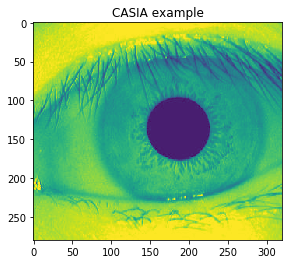

In [26]:
from matplotlib import pyplot as plt
gray = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
plt.imshow(gray)
plt.title('CASIA example')
plt.show()

In [28]:
import sys
sys.path.append("c:\knu\piton4")
from bn256 import *

In [29]:
import random

class Alexa_Hamming:
    #using standart Python integer type

    @staticmethod
    def get_random_vector_of_minusOneAndOnes(xSize = 16):
        return [random.randrange(-1, 2, 2) for xIndex in range(xSize)]
    
    @staticmethod
    def set_of_types(*args):
        xSet_of_types = set([])
        for arg in args:
            xSet_of_types.add(type(arg))
        return xSet_of_types
    
    @staticmethod
    def is_iterable_object(arg):
        try:
            iterator = iter(arg)
            #print(arg, 'is iterable')
            return True
        except TypeError as iterator_error:
            #print(arg, 'is not iterable')
            return False
        
    @staticmethod
    def is_iterable(*args):
        for arg in args:
            if Alexa_Hamming.is_iterable_object(arg):
                pass
            else:
                return False
        return True
        
    @staticmethod
    def is_size_the_same(*args):
        xSet_of_sizes = set([])
        for arg in args:
            xSet_of_sizes.add(len(arg))
        if 1 == len(xSet_of_sizes):
            return True
        else:
            return False

    @staticmethod
    def inner_product(xVec1, xVec2):
        xSigned_inner_product = 0
        for i in range(len(xVec1)):
            xSigned_inner_product += (xVec1[i]*xVec2[i])
        return xSigned_inner_product
    
    @staticmethod
    def different_bits_via_inner_product(xVec1, xVec2):
        return ((len(xVec1) - Alexa_Hamming.inner_product(xVec1, xVec2)) // 2)
    
    @staticmethod
    def hamming_distance(xVec1, xVec2, xType = list):
        assert Alexa_Hamming.is_iterable(xVec1, xVec2), \
        "at least one of arg is not iterable object (could not be a vector)"
        assert set([xType]) == Alexa_Hamming.set_of_types(xVec1, xVec2), \
        "objects are of different types or function needs other types of vectors"
        assert Alexa_Hamming.is_size_the_same(xVec1, xVec2), \
        "the size (length) of args (vectors) are not the same"
        xSize = len(xVec1)
        return (Alexa_Hamming.different_bits_via_inner_product(xVec1, xVec2)/xSize)

    @staticmethod
    def hamming_distance_typeList_fast(xVec1, xVec2, xSize = 16):
        return ((xSize - sum([xVec1[i]*xVec2[i] for i in range(xSize)])) / (2*xSize))
    
    @staticmethod
    def hamming_distance_typeList_length16_fast(xVec1, xVec2):
        return ((16 - sum([xVec1[i]*xVec2[i] for i in range(16)])) / 32)

In [30]:
import copy
G1_generator = copy.deepcopy(curve_G)
G2_generator = copy.deepcopy(twist_G)
G1 = copy.deepcopy(g1_scalar_base_mult(1))
G2 = copy.deepcopy(g2_scalar_base_mult(1))
invG1  = G1.scalar_mul(gfp_1(order-1).value())
invG2 = copy.deepcopy(G2)
invG2.negate()
#========================================
alpha = rand_elem()
beta  = rand_elem()
H1 = copy.deepcopy(g1_scalar_base_mult(alpha))
H2 = copy.deepcopy(g2_scalar_base_mult(beta))

In [43]:
import collections
mskT = collections.namedtuple('mskT',     ['h_g1', 's_vector', 't_vector', 'h_g2', 'u_vector', 'v_vector'])
#xMsk = mskT._make((gen1_h, s_vector, t_vector, gen2_h, u_vector, v_vector))
#==============================================
class Alexa_IPE_Setup:
    
    def __init__(self, n, g1, g2, h1, h2, inv_g1 = None, inv_g2 = None):
        self.n  = n
        self.G1 = g1
        self.G2 = g2
        self.H1 = h1
        self.H2 = h2
        self.invG1 = inv_g1
        self.invG2 = inv_g2
        self.msk = Alexa_IPE_Setup.get_msk(self.n, self.G1, self.G2, self.H1, self.H2)
    
    @staticmethod
    def get_msk(n, g1, g2, h1, h2):
        s_vector = [ rand_elem() for i in range(n) ]
        t_vector = [ rand_elem() for i in range(n) ]
        u_vector = [ rand_elem() for i in range((n+2)) ]
        v_vector = [ rand_elem() for i in range((n+2)) ]
        gen1_h = [ g1_add(G1.scalar_mul(s_vector[i]), h1.scalar_mul(t_vector[i])) for i in range(n) ]
        gen2_h = [ g2_add(G2.scalar_mul(u_vector[i]), h2.scalar_mul(v_vector[i])) for i in range((n+2)) ]
        return mskT._make((gen1_h, s_vector, t_vector, gen2_h, u_vector, v_vector))
    
    @staticmethod
    def oneToGminusOneToInvG(xOneminusOne, G, invG):
        assert xOneminusOne in [-1,1], " def oneToG1minusOneToInvG1(xOneminusOne, G, invG): argument type|range ERROR "
        if -1 == xOneminusOne:
            return invG
        else:
            return G
        
    @staticmethod
    def vectorOfNumberToVectorOfPoints(xVector, G, invG):
        assert set(xVector).issubset(set([-1,1])), " ERROR "
        return [ Alexa_IPE_Setup.oneToGminusOneToInvG(xElement, G, invG) for xElement in xVector ]
    
#==============================================

class Alexa_IPE_Registration:
    
    def __init__(self, msk, c_vector, n):
        self.msk = msk
        self.c = c_vector
        self.n = n
        self.r0 = rand_elem()
        self.reg_template = []
        self.reg_template.append(G2.scalar_mul(self.r0))
        self.reg_template.append(H2.scalar_mul(self.r0))
        self.h2 = self.msk.h_g2
        self.reg_template += [xElement.scalar_mul(self.r0) for xElement in self.h2 ]
        #
        self.powers = self.msk.s_vector
        self.ProductTemp = \
        Alexa_IPE_Registration.akaProduct_g2(self.c, self.powers, 0, n, 0, 0)
        self.reg_template[2] = g2_add(self.reg_template[2], self.ProductTemp.scalar_mul(order-1))
        #
        self.powers = self.msk.t_vector
        self.ProductTemp = \
        Alexa_IPE_Registration.akaProduct_g2(self.c, self.powers, 0, n, 0, 0)
        self.reg_template[3] = g2_add(self.reg_template[3], self.ProductTemp.scalar_mul(order-1))
        #
        for i in range(0, self.n, 1):
            self.reg_template[i+4] = g2_add(self.reg_template[i+4], self.c[i])
           
    @staticmethod            
    def akaProduct_g2(c_vector, power_vector, j, n, shift_c_index = 0, shift_power_index = 0):
        xAkaProduct = c_vector[j + shift_c_index].scalar_mul(power_vector[j + shift_power_index])
        for i in range((1+j), n, 1):
            temp = c_vector[i + shift_c_index].scalar_mul(power_vector[i + shift_power_index])
            xAkaProduct = g2_add(xAkaProduct, temp)
            del temp
        return xAkaProduct
    
#==============================================
class Alexa_IPE_Authentication:
    
    def __init__(self, msk, c_vector, n):
        self.msk = msk
        self.c = c_vector
        self.n = n
        self.r0 = rand_elem()
        self.auth_template = []
        self.G1zero = G1.scalar_mul(0)
        self.auth_template.append(self.G1zero)
        self.auth_template.append(self.G1zero)
        self.auth_template.append(G1.scalar_mul(self.r0))
        self.auth_template.append(H1.scalar_mul(self.r0))
        #
        self.h1 = self.msk.h_g1
        self.auth_template += [g1_add(self.h1[i].scalar_mul(self.r0), self.c[i]) for i in range(self.n) ]
        #
        self.powers = self.msk.u_vector
        self.ProductTemp = \
        Alexa_IPE_Authentication.akaProduct_g1(self.auth_template, self.powers, 0, (self.n + 2), 2, 0)
        self.auth_template[0] = self.ProductTemp.scalar_mul(order-1)
        #
        self.powers = self.msk.v_vector
        self.ProductTemp = \
        Alexa_IPE_Authentication.akaProduct_g1(self.auth_template, self.powers, 0, (self.n + 2), 2, 0)
        self.auth_template[1] = self.ProductTemp.scalar_mul(order-1)

    @staticmethod            
    def akaProduct_g1(c_vector, power_vector, j, n, shift_c_index = 0, shift_power_index = 0):
        xAkaProduct = c_vector[j + shift_c_index].scalar_mul(power_vector[j + shift_power_index])
        for i in range((1+j),n, 1):
            temp = c_vector[i + shift_c_index].scalar_mul(power_vector[i + shift_power_index])
            xAkaProduct = g1_add(xAkaProduct, temp)
            del temp
        return xAkaProduct
#==============================================
class Alexa_IPE_Decryption:
    
    def __init__(self, pairing, g1, g2, reg_template, auth_template):
        assert len(auth_template) == len(reg_template) , " ERORR : templates of different length "
        self.n  = len(auth_template)
        self.k = (self.n - 4)
        self.G1 = g1
        self.G2 = g2
        self.pairing = pairing
        self.reg_template  = reg_template
        self.auth_template = auth_template
        self.pairingG2G1 = self.pairing(self.G2, self.G1)
        self.pairingOfTemplates = None
        self.inner_product = None
        self.hamming_dictance = None

    def get_inner_product(self):
        assert self.pairingOfTemplates is not None
        flag = True
        xPower = 0
        gt_temp     = gt_scalar_mult(self.pairingG2G1, xPower)
        if  gt_temp == self.pairingOfTemplates:
            self.inner_product =  xPower
        else:
            xPower += 2
            gt_temp2    = gt_scalar_mult(self.pairingG2G1, 2)
            gt_temp     = gt_temp2
            gt_temp2Inv = gt_temp2.inverse()
            gt_tempInv  = gt_temp2Inv
            while flag:
                if self.k < xPower:
                    flag = False
                else:
                    if  gt_tempInv == self.pairingOfTemplates:
                        self.inner_product = -xPower
                        flag = False
                    elif gt_temp == self.pairingOfTemplates:
                        self.inner_product =  xPower
                        flag = False
                    else:
                        gt_temp    = gt_add(gt_temp, gt_temp2)
                        gt_tempInv = gt_add(gt_tempInv, gt_temp2Inv)
                        xPower += 2
                        pass

    def get_hamming_dictance(self):
        assert self.inner_product is not None
        self.hamming_dictance = ((self.k - self.inner_product) / (2*self.k))
                    
    def get_pairing_of_templates(self):
        self.pairingOfTemplates = Alexa_IPE_Decryption.get_pairing_of_templates_staticmethod(self.pairing, self.reg_template, self.auth_template)
                
    @staticmethod
    def get_pairing_of_templates_staticmethod(pairing, dk_vector, ct_vector):
        assert len(dk_vector) == len(ct_vector) , " ERORR : templates of different length "
        n = len(dk_vector)
        pairing_list = [pairing(dk_vector[i], ct_vector[i]) \
                  for i in range(n)]
        product = pairing_list[0]
        for i in range(1,n, 1):
            product = gt_add(product, pairing_list[i])
        del pairing_list
        return product
#==============================================

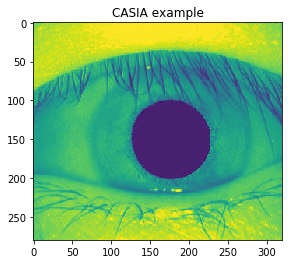

In [98]:
gray = cv2.imread(im_filename_010_1_1, cv2.IMREAD_GRAYSCALE)
plt.imshow(gray)
plt.title('CASIA example')
plt.show()

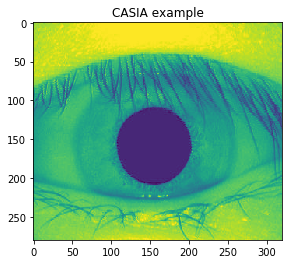

In [99]:
gray = cv2.imread(im_filename_010_1_2, cv2.IMREAD_GRAYSCALE)
plt.imshow(gray)
plt.title('CASIA example')
plt.show()

In [71]:
import datetime
time_start = datetime.datetime.now()
#==============================================
im_filename_010_1_1 = 'g:\Mat===\\eyes\\010_1_1.jpg'
im_filename_010_1_2 = 'g:\Mat===\\eyes\\010_1_2.jpg'

time_start_Alexa_IPE_Iris_Vector_v1 = datetime.datetime.now()
xAlexa_IPE_Iris_Vector_1 = Alexa_IPE_Iris_Vector(im_filename_010_1_2, 128, 8, 8)
v1 = xAlexa_IPE_Iris_Vector_1.IPE_vector
#v1 = ([ 1 for i in range(64)] + [ -1 for i in range(64)])
time_end_Alexa_IPE_Iris_Vector_v1 = datetime.datetime.now()
timedelta_Alexa_IPE_Iris_Vector_v1 = \
(time_end_Alexa_IPE_Iris_Vector_v1 - time_start_Alexa_IPE_Iris_Vector_v1)

time_start_Alexa_IPE_Iris_Vector_v2 = datetime.datetime.now()
xAlexa_IPE_Iris_Vector_2 = Alexa_IPE_Iris_Vector(im_filename_010_1_2, 128, 8, 8)
v2 = xAlexa_IPE_Iris_Vector_2.IPE_vector
#v2 = ([ 1 for i in range(64)] + [ 1 for i in range(64)])
time_end_Alexa_IPE_Iris_Vector_v2 = datetime.datetime.now()
timedelta_Alexa_IPE_Iris_Vector_v2 = \
(time_end_Alexa_IPE_Iris_Vector_v2 - time_start_Alexa_IPE_Iris_Vector_v2)
#==============================================
time_start_Alexa_IPE_Setup = datetime.datetime.now()
xAlexa_IPE_Setup = Alexa_IPE_Setup(len(v1), G1, G2, H1, H2, invG1, invG2)
time_end_Alexa_IPE_Setup = datetime.datetime.now()
timedelta_Alexa_IPE_Setup = (time_end_Alexa_IPE_Setup - time_start_Alexa_IPE_Setup)
#==============================================
v1_as_points = Alexa_IPE_Setup.vectorOfNumberToVectorOfPoints(v1, xAlexa_IPE_Setup.G2, xAlexa_IPE_Setup.invG2)
v2_as_points = Alexa_IPE_Setup.vectorOfNumberToVectorOfPoints(v2, xAlexa_IPE_Setup.G1, xAlexa_IPE_Setup.invG1)
#==============================================
time_start_xAlexa_IPE_Registration = datetime.datetime.now()
xAlexa_IPE_Registration = \
Alexa_IPE_Registration(xAlexa_IPE_Setup.msk, Alexa_IPE_Setup.vectorOfNumberToVectorOfPoints(v1, G2, invG2), len(v1))
assert len(xAlexa_IPE_Registration.reg_template) == (4 + len(v1)), " somthing wrong "
time_end_xAlexa_IPE_Registration = datetime.datetime.now()
timedelta_xAlexa_IPE_Registration = \
(time_end_xAlexa_IPE_Registration - time_start_xAlexa_IPE_Registration)
#==============================================
time_start_xAlexa_IPE_Authentication = datetime.datetime.now()
xAlexa_IPE_Authentication = \
Alexa_IPE_Authentication(xAlexa_IPE_Setup.msk, Alexa_IPE_Setup.vectorOfNumberToVectorOfPoints(v2, G1, invG1), len(v2))
assert len(xAlexa_IPE_Authentication.auth_template) == (4 + len(v2)), " somthing wrong "
assert len(xAlexa_IPE_Authentication.auth_template) == len(xAlexa_IPE_Registration.reg_template), " somthing wrong "
time_end_xAlexa_IPE_Authentication = datetime.datetime.now()
timedelta_xAlexa_IPE_Authentication = \
(time_end_xAlexa_IPE_Authentication - time_start_xAlexa_IPE_Authentication)
#==============================================
time_start_xAlexa_IPE_Decryption_init = datetime.datetime.now()
xAlexa_IPE_Decryption = \
Alexa_IPE_Decryption(optimal_ate, G1, G2, xAlexa_IPE_Registration.reg_template, xAlexa_IPE_Authentication.auth_template)
time_end_xAlexa_IPE_Decryption_init = datetime.datetime.now()
timedelta_xAlexa_IPE_Decryption_init = \
(time_end_xAlexa_IPE_Decryption_init - time_start_xAlexa_IPE_Decryption_init)

time_start_Alexa_IPE_Decryption_get_pairing_of_templates = datetime.datetime.now()
xAlexa_IPE_Decryption.get_pairing_of_templates()
time_end_Alexa_IPE_Decryption_get_pairing_of_templates = datetime.datetime.now()
timedelta_Alexa_IPE_Decryption_get_pairing_of_templates = \
(time_end_Alexa_IPE_Decryption_get_pairing_of_templates - time_start_Alexa_IPE_Decryption_get_pairing_of_templates)

time_start_Alexa_IPE_Decryption_get_inner_product = datetime.datetime.now()
xAlexa_IPE_Decryption.get_inner_product()
time_end_Alexa_IPE_Decryption_get_inner_product = datetime.datetime.now()
timedelta_Alexa_IPE_Decryption_get_inner_product = \
(time_end_Alexa_IPE_Decryption_get_inner_product - time_start_Alexa_IPE_Decryption_get_inner_product)

time_start_Alexa_IPE_Decryption_get_hamming_dictance = datetime.datetime.now()
xAlexa_IPE_Decryption.get_hamming_dictance()
time_end_Alexa_IPE_Decryption_get_hamming_dictance = datetime.datetime.now()
timedelta_Alexa_IPE_Decryption_get_hamming_dictance = \
(time_end_Alexa_IPE_Decryption_get_hamming_dictance - time_start_Alexa_IPE_Decryption_get_hamming_dictance)
timedelta_xAlexa_IPE_Decryption = \
(timedelta_xAlexa_IPE_Decryption_init + timedelta_Alexa_IPE_Decryption_get_pairing_of_templates + \
timedelta_Alexa_IPE_Decryption_get_inner_product + timedelta_Alexa_IPE_Decryption_get_hamming_dictance)
#==============================================
time_end = datetime.datetime.now()
timedelta = (time_end - time_start)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:957: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:997: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [49]:
time_start_Alexa_IPE_Decryption_get_hamming_dictance = datetime.datetime.now()
xAlexa_IPE_Decryption.get_hamming_dictance()
time_end_Alexa_IPE_Decryption_get_hamming_dictance = datetime.datetime.now()
timedelta_Alexa_IPE_Decryption_get_hamming_dictance = \
(time_end_Alexa_IPE_Decryption_get_hamming_dictance - time_start_Alexa_IPE_Decryption_get_hamming_dictance)
timedelta_xAlexa_IPE_Decryption = \
(timedelta_xAlexa_IPE_Decryption_init + timedelta_Alexa_IPE_Decryption_get_pairing_of_templates + \
timedelta_Alexa_IPE_Decryption_get_inner_product + timedelta_Alexa_IPE_Decryption_get_hamming_dictance)

In [89]:
print(timedelta_Alexa_IPE_Iris_Vector_v1.total_seconds(), " (seconds)")
print(timedelta_Alexa_IPE_Iris_Vector_v2.total_seconds(), " (seconds)")

5.089291  (seconds)
5.06129  (seconds)


In [90]:
print(timedelta_Alexa_IPE_Setup.total_seconds(), " (seconds)")

56.245217  (seconds)


In [91]:
print(timedelta_xAlexa_IPE_Registration.total_seconds(), " (seconds)")

66.27079  (seconds)


In [92]:
print(timedelta_xAlexa_IPE_Authentication.total_seconds(), " (seconds)")

18.647067  (seconds)


In [93]:
print(timedelta_xAlexa_IPE_Decryption_init.total_seconds(), " (seconds)")

0.457026  (seconds)


In [94]:
print(timedelta_Alexa_IPE_Decryption_get_pairing_of_templates.total_seconds(), " (seconds)")

61.678528  (seconds)


In [95]:
print(timedelta_Alexa_IPE_Decryption_get_inner_product.total_seconds(), " (seconds)")

0.140008  (seconds)


In [64]:
print(timedelta_Alexa_IPE_Decryption_get_hamming_dictance.total_seconds(), " (seconds)")

0


In [96]:
print(timedelta_xAlexa_IPE_Decryption.total_seconds(), " (seconds)")

62.275562  (seconds)


In [87]:
timedelta_IPE = \
timedelta_Alexa_IPE_Setup + \
timedelta_xAlexa_IPE_Registration + \
timedelta_xAlexa_IPE_Authentication + \
timedelta_xAlexa_IPE_Decryption
print(timedelta_IPE.total_seconds()/60, " (minutes)")
print(timedelta_IPE.total_seconds(), " (seconds)")
print((10**6)*timedelta_IPE.total_seconds(), " (microseconds)")

3.3906439333333336  (minutes)
203.438636  (seconds)
203438636.0  (microseconds)


In [88]:
timedelta_total = \
timedelta_Alexa_IPE_Iris_Vector_v1 + \
timedelta_Alexa_IPE_Iris_Vector_v2 + \
timedelta_IPE
print(timedelta_total.total_seconds()/60, " (minutes)")
print(timedelta_total.total_seconds(), " (seconds)")
print((10**6)*timedelta_total.total_seconds(), " (microseconds)")

3.559820283333333  (minutes)
213.589217  (seconds)
213589217.0  (microseconds)


In [97]:
print(" inner product via IPE : ")
print(xAlexa_IPE_Decryption.inner_product)
print(" hamming dictance via IPE : ")
print(xAlexa_IPE_Decryption.hamming_dictance)

 inner product via IPE : 
128
 hamming dictance via IPE : 
0.0


In [100]:
print(" inner product via initial vectors : ")
print(Alexa_Hamming.inner_product(v1, v2))
print(" inner product via hamming distance : ")
print(Alexa_Hamming.hamming_distance(v1, v2))

 inner product via initial vectors : 
128
 inner product via hamming distance : 
0.0
